# Minimal Operon Detection with polars-bio

This notebook shows a compact pipeline:
- Read GFF with polars-bio
- Merge CDS within `max_gap` to form operon windows
- Overlap CDS back onto windows to assemble operon members
- Optional keyword filtering
- Quick interval visualization


In [ ]:
import polars as pl
import polars_bio as pb
from pathlib import Path
import matplotlib.pyplot as plt

GFF_PATH = '../data/test.gff'
MAX_GAP = 50
MIN_GENES = 2
KEYWORDS = ['crispr','cas' ]


MIN_KEYWORD_HITS = 1
SAME_STRAND_ONLY = True

/home/tgambin/workspace/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load CDS and set interval types expected by polars-bio ops
cds = (
    #pb.read_gff(GFF_PATH, attr_fields=['ID','Name','product'])
    pb.scan_gff(GFF_PATH, attr_fields=['ID','Name','product'])
    .filter(pl.col('type')=='CDS')
    .select(['chrom','strand','start','end','ID','Name','product'])
    .with_columns([pl.col('start').cast(pl.UInt32), pl.col('end').cast(pl.UInt32)])
)
cds.collect().head()

7rows [00:00, 3647.67rows/s]


chrom,strand,start,end,ID,Name,product
str,str,u32,u32,str,str,str
"""chr1""","""+""",100,300,"""cds1""","""geneA""","""CRISPR-associated protein Cas1"""
"""chr1""","""+""",310,500,"""cds2""","""geneB""","""hypothetical protein"""
"""chr1""","""+""",520,700,"""cds3""","""geneC""","""CRISPR repeat-binding protein"""
"""chr1""","""+""",900,1100,"""cds4""","""geneD""","""transposase"""
"""chr1""","""+""",1110,1300,"""cds5""","""geneE""","""Cas3 helicase"""


In [5]:
# polars-bio driven detect_operons: merge + overlap (minimal)
def merged_operon_windows(cds_df: pl.LazyFrame, max_gap: int) -> pl.LazyFrame:
    parts = []
    parts.append(pb.merge(cds_df.select(['chrom','start','end']), min_dist=max_gap, cols=['chrom','start','end'], output_type='polars.LazyFrame'))
    if not parts:
        return pl.LazyFrame()
    merged = pl.concat(parts, how='diagonal_relaxed')
    by = ['chrom'] 
    merged = merged.sort(by + ['start']).with_columns(pl.int_range(0, pl.len()).over(by).alias('cluster_id'))
    return merged

def detect_operons_pb(cds_df: pl.LazyFrame, max_gap: int, min_genes: int, keywords=None, min_keyword_hits: int=0) -> pl.LazyFrame:
    merged = merged_operon_windows(cds_df, max_gap=max_gap)
    iv1 = cds_df.select(['chrom','start','end','ID','Name','product'])
    iv2 = merged.select(['chrom','start','end'] + ['cluster_id'])
    ov = pb.overlap(iv1, iv2, cols1=['chrom','start','end'], cols2=['chrom','start','end'], suffixes=('_gene','_operon'), output_type='polars.LazyFrame')
    toks = sorted(set([k.strip() for k in (keywords or []) if k and k.strip()]))
    patt = '(?i)(' + '|'.join(toks) + ')' if toks else None
    has_kw = pl.lit(False) if not patt else pl.col('product_gene').cast(pl.Utf8).fill_null('').str.contains(patt, literal=False)
    ov = ov.with_columns(has_kw.alias('has_keyword'))
    
    group_keys = ['chrom_operon']  + ['cluster_id_operon']
    ops = ov.group_by(group_keys).agg([
        pl.col('start_operon').min().alias('operon_start'),
        pl.col('end_operon').max().alias('operon_end'),
        pl.len().alias('gene_count'),
        pl.col('ID_gene').implode().alias('member_ids'),
        pl.col('Name_gene').implode().alias('member_names'),
        pl.col('product_gene').implode().alias('member_products'),
        pl.col('has_keyword').sum().alias('keyword_hits'),
    ])
    ops = ops.filter(pl.col('gene_count') >= min_genes)
    if min_keyword_hits > 0:
        ops = ops.filter(pl.col('keyword_hits') >= min_keyword_hits)
    return ops.sort(group_keys[:-1] + ['operon_start'])


In [6]:
# Run detection
ops = detect_operons_pb(cds, MAX_GAP, MIN_GENES, KEYWORDS, MIN_KEYWORD_HITS)
# Flatten list columns for compact display
def flatten_lists(df: pl.LazyFrame) -> pl.LazyFrame:
    lcols = [name for name, dt in df.schema.items() if isinstance(dt, pl.List)]
    return df.with_columns([pl.col(c).list.join('|').alias(c) for c in lcols]) if lcols else df
flatten_lists(ops).sink_csv('operons_detected.csv')
ops.collect()

7rows [00:00, 6013.95rows/s]
7rows [00:00, 6898.53rows/s]
/tmp/ipykernel_70228/2315145136.py:5: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  lcols = [name for name, dt in df.schema.items() if isinstance(dt, pl.List)]
7rows [00:00, 4496.88rows/s]
7rows [00:00, 5244.75rows/s]


chrom_operon,cluster_id_operon,operon_start,operon_end,gene_count,member_ids,member_names,member_products,keyword_hits
str,i64,u32,u32,u32,list[str],list[str],list[str],u32
"""chr1""",0,100,700,3,"[""cds1"", ""cds2"", ""cds3""]","[""geneA"", ""geneB"", ""geneC""]","[""CRISPR-associated protein Cas1"", ""hypothetical protein"", ""CRISPR repeat-binding protein""]",2
"""chr1""",1,900,1300,2,"[""cds4"", ""cds5""]","[""geneD"", ""geneE""]","[""transposase"", ""Cas3 helicase""]",1


7rows [00:00, 5197.40rows/s]
7rows [00:00, 6378.48rows/s]


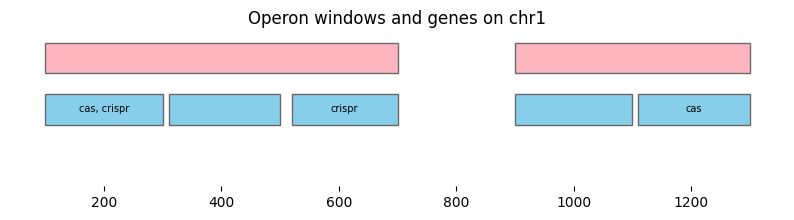

In [7]:
# Visualization: detected operon windows (pink) and member genes (blue);
# put keyword labels inside gene boxes.
import bioframe as bf

ops_df = ops.collect()

if ops_df is not None and not ops_df.is_empty():
    # Plot per contig for clarity
    for chrom in ops_df.select(pl.col('chrom_operon')).unique().to_series().to_list():
        sub = ops_df.filter(pl.col('chrom_operon') == chrom)
        if sub.is_empty():
            continue
        pdf = sub.to_pandas()
        # Window intervals (operons)
        win_starts = pdf['operon_start'].tolist()
        win_ends = pdf['operon_end'].tolist()
        n_win = len(win_starts)
        xmin, xmax = min(win_starts), max(win_ends)
        pad = max(1, int(0.05 * (xmax - xmin)))
        # Collect genes overlapping any detected window on this contig
        iv2 = pl.DataFrame({'chrom': [chrom]*n_win, 'start': win_starts, 'end': win_ends})
        genes_chrom = cds.filter(pl.col('chrom') == chrom).select(['chrom','start','end','ID','Name','product']).collect()
        ov = pb.overlap(
            genes_chrom, iv2,
            cols1=['chrom','start','end'], cols2=['chrom','start','end'],
            suffixes=('_gene','_win'), output_type='polars.DataFrame'
        )
        # Resolve column names robustly 
        def pick(cols, cands):
            for c in cands:
                if c in cols:
                    return c
            return None
        if not ov.is_empty():
            cols = set(ov.columns)
            gs_col = pick(cols, ['start_gene','start_win','start_1','start_2','start'])
            ge_col = pick(cols, ['end_gene','end_win','end_1','end_2','end'])
            id_col = pick(cols, ['ID_gene','ID_win','ID_1','ID_2','ID'])
            nm_col = pick(cols, ['Name_gene','Name_win','Name_1','Name_2','Name'])
            pr_col = pick(cols, ['product_gene','product_win','product_1','product_2','product'])
            sel = [c for c in [gs_col, ge_col, id_col, nm_col, pr_col] if c]
            genes_pl = ov.select(sel)
            subset = [id_col] if id_col else [gs_col, ge_col]
            genes_pl = genes_pl.unique(subset=subset)
            genes = genes_pl.to_pandas()
            gene_starts = genes[gs_col].tolist()
            gene_ends = genes[ge_col].tolist()
        else:
            genes = None
            gene_starts = []
            gene_ends = []
        
        starts_all = win_starts + gene_starts
        ends_all = win_ends + gene_ends
        colors_all = (['lightpink'] * n_win) + (['skyblue'] * len(gene_starts))
        levels_all = ([2] * n_win) + ([1] * len(gene_starts))
        bf.vis.plot_intervals_arr(
            starts=starts_all, ends=ends_all,
            colors=colors_all, levels=levels_all,
            xlim=(xmin - pad, xmax + pad), show_coords=True,
        )
        ax = plt.gca()
        ax.set_aspect('auto')
        # Put keyword labels inside gene boxes
        if genes is not None and not genes.empty:
            # Choose available product/name column for labeling
            label_col = 'product_gene' if 'product_gene' in genes.columns else ('product_win' if 'product_win' in genes.columns else ('product_1' if 'product_1' in genes.columns else ('product_2' if 'product_2' in genes.columns else ('product' if 'product' in genes.columns else (nm_col if (nm_col and nm_col in genes.columns) else None)))))
            labels = genes[label_col].tolist() if label_col else [''] * len(gene_starts)
            for gs, ge, prod in zip(gene_starts, gene_ends, labels):
                txt = []
                for kw in (KEYWORDS or []):
                    try:
                        if kw and str(kw).strip() and str(kw).lower() in str(prod).lower():
                            txt.append(str(kw))
                    except Exception:
                        pass
                if txt:
                    ax.text((gs+ge)/2, 1, ', '.join(sorted(set(txt))),
                            ha='center', va='center', fontsize=7, color='black', clip_on=True)
        plt.title(f'Operon windows and genes on {chrom}')
        plt.show()
else:
    print('No detected operons to visualize')
